# Variational Autoencoder (VAE)
* #### Get reduced feature vectors (16-dimension) from monomer sequences (32-dimension) using VAE

### 1. Train VAE


In [15]:
# import
import torch
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from vae.encoder import Encoder
from vae.decoder import Decoder
from vae.train import train_model
from vae.utils.torch import FullyConnectedNeuralNetwork, TrainedVAE
from vae.utils.function import get_blockiness, plot_two_pairs_color_map

In [16]:
# prepare data
print("Data processing ...", flush=True)
df_a = pd.read_csv('./data/dataSetA.csv', sep='  ', engine='python', header=None)
df_b = pd.read_csv('./data/dataSetB.csv', sep='  ', engine='python', header=None)
df_c = pd.read_csv('./data/dataSetC.csv', sep='  ', engine='python', header=None)
df_d = pd.read_csv('./data/dataSetD.csv', sep='  ', engine='python', header=None)

df_total = pd.concat([df_a, df_b, df_c, df_d], axis=0)

# get volume fraction and blockiness
sequence_list = list()
for idx, row in df_total.iterrows():
    sequence = ''
    modified_row = row[1: -1]
    for num in modified_row:
        sequence += str(int(num))
    sequence_list.append(sequence)

df_total['sequence'] = sequence_list
df_total['0_fraction'] = df_total['sequence'].apply(lambda x: x.count('0') / 32.0)
df_total['1_fraction'] = df_total['sequence'].apply(lambda x: x.count('1') / 32.0)
df_total['blockiness'] = df_total['sequence'].apply(lambda x: get_blockiness(x))
df_total['interaction_parameter'] = df_total[0]
df_total['lamellar_period'] = df_total[33]
df_total = df_total.drop(labels=['sequence', 0, 33], axis=1)

Data processing ...


In [17]:
# prepare train / test dataset
dtype = torch.float32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# preprocess sequence data
sequence_arr = df_total.iloc[:, :32].values.tolist()
x_data = torch.zeros(size=(len(sequence_arr), 32, 2), dtype=dtype, device=device)  # 32 (total) / only 2 beads
# x_data.fill_(value=1.0 / (1.0 + np.exp(1.0)))
for num in range(len(sequence_arr)):
    for idx in range(32):  # total 32 monomers
        if sequence_arr[num][idx] == 0:
            # x_data[num, idx, 0] = np.exp(1.0) / (1.0 + np.exp(1.0))  # soft max
            x_data[num, idx, 0] = 1.0
        else:
            # x_data[num, idx, 1] = np.exp(1.0) / (1.0 + np.exp(1.0))
            x_data[num, idx, 1] = 1.0

# preparation training data (target and features)
y_with_feature = df_total.iloc[:, 32:]

# set and fit the scalers
scaler_list = [StandardScaler() for _ in range(y_with_feature.shape[1])]
for idx, scaler in enumerate(scaler_list):
    scaler.fit(y_with_feature.iloc[:, idx].values.reshape(-1, 1))

x_train, x_test, y_with_feature_train, y_with_feature_test = train_test_split(x_data, y_with_feature, test_size=0.2)

y_with_feature_train = torch.tensor(y_with_feature_train.values, dtype=dtype, device=device)
y_with_feature_test = torch.tensor(y_with_feature_test.values, dtype=dtype, device=device)

In [18]:
# set encoder, decoder, and property network
encoder = Encoder(
    in_dimension=64,  # 32 * 2
    layer_1d=40,
    layer_2d=32,
    layer_3d=24,
    latent_dimension=16
).to(device)

decoder = Decoder(
    latent_dimension=16,
    gru_neurons_num=16,
    gru_stack_size=2,
    out_dimension=2  # bead 0 or 1
).to(device)

property_network = FullyConnectedNeuralNetwork(
    input_dim=16+4,  # latent dimension + feature dimension
    hidden_sizes=[8],
    output_dim=1
).to(device)

start training
num_epochs:  1


  0%|          | 0/80 [03:51<?, ?it/s]

===== EPOCH 1 =====
Training ...



100%|██████████| 80/80 [00:03<00:00, 38.14it/s, property_loss=0.81, vae_loss=0.66]
81it [00:03, 37.65it/s, property_loss=0.81, vae_loss=0.66]                        
81it [00:03, 37.65it/s, property_loss=0.76, vae_loss=0.68]
82it [00:03, 37.65it/s, property_loss=0.82, vae_loss=0.67]
83it [00:03, 37.65it/s, property_loss=1.17, vae_loss=0.65]
84it [00:03, 37.65it/s, property_loss=0.68, vae_loss=0.71]
90it [00:03, 47.72it/s, property_loss=0.68, vae_loss=0.71]
90it [00:03, 47.72it/s, property_loss=0.40, vae_loss=0.68]
91it [00:03, 47.72it/s, property_loss=0.66, vae_loss=0.71]
92it [00:03, 47.72it/s, property_loss=0.59, vae_loss=0.68]
93it [00:03, 47.72it/s, property_loss=1.45, vae_loss=0.70]
94it [00:03, 47.72it/s, property_loss=0.66, vae_loss=0.68]
95it [00:03, 47.72it/s, property_loss=0.67, vae_loss=0.71]
96it [00:03, 43.53it/s, property_loss=0.67, vae_loss=0.71]
96it [00:03, 43.53it/s, property_loss=0.71, vae_loss=0.70]
97it [00:03, 43.53it/s, property_loss=1.06, vae_loss=0.68]
98it [0

Validation ...
Loss is 1.234
Elementary quality score is 63.014 / 100
Sequence quality score is 0.775 / 100
EPOCH 1 takes 0.072 minutes
Final elementary quality score is 62.463 / 100
Final S=sequence quality score is 0.931 / 100


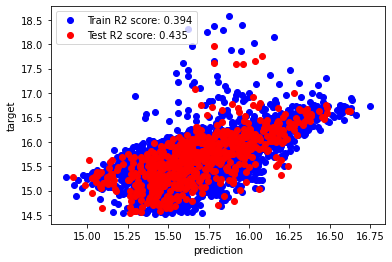

In [19]:
# training
print("start training", flush=True)
trained_encoder, trained_decoder, trained_property_network = train_model(
    vae_encoder=encoder,
    vae_decoder=decoder,
    property_network=property_network,
    x_train=x_train,
    x_test=x_test,
    y_train=y_with_feature_train,
    y_test=y_with_feature_test,
    num_epochs=1000,
    batch_size=32,
    lr_enc=0.001,
    lr_dec=0.001,
    lr_property=0.001,
    KLD_alpha=1e-6,
    sample_num=1000,
    dtype=dtype,
    device=device,
    save_file_name='total_1000.png',
    scaler_list=scaler_list
)

In [21]:
# save vae
trained_vae = TrainedVAE(
    encoder=trained_encoder,
    decoder=trained_decoder,
    property_network=trained_property_network,
    scaler_list=scaler_list,
    scaler_key=y_with_feature.columns.tolist()
)
torch.save(trained_vae, 'vae/trained_vae/trained_1000.pth')

### 2. Get reduced (16-dimensional) feature vectors using principal analysis

In [24]:
# principal analysis
with torch.no_grad():
    trained_vae = torch.load('vae/trained_vae/trained_1000.pth')
    total_inp_flat_one_hot = x_data.flatten(start_dim=1)  # [b, 32*2]
    total_latent_points, mus, log_vars = trained_vae.encoder(total_inp_flat_one_hot)  # [b, latent_dimension]

    # principal component analysis
    n_components = 16
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(total_latent_points)
    principal_df = pd.DataFrame(
        data=principal_components,
        columns=['principal_component_%d' % (num + 1) for num in range(n_components)]
    )

    final_df = pd.concat([principal_df, y_with_feature[['lamellar_period', 'interaction_parameter']]], axis=1)

ModuleNotFoundError: No module named 'utils'

In [ ]:
# plot explained variance by principal component analysis
exp_var_pca = pca.explained_variance_ratio_

plt.bar(range(0, len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center',
        label='Individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
# plot
# x-component (1) principal component 1
# y-component (2) interaction parameter
# z-component (3) lamellar period

plot_two_pairs_color_map(
    x_list=final_df['principal_component_1'].values.tolist(),
    y_list=final_df['interaction_parameter'].values.tolist(),
    z_list=final_df['lamellar_period'].values.tolist(),
    x_name='principal_component_1',
    y_name='interaction_parameter',
    z_name='lamellar_period',
    title='2 component PCA'
)